In [1]:
# Data Science Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import random

# Microscopy Related Imports
import openslide
import tifffile

# Cloud Related Imports
from google.protobuf.struct_pb2 import Value
from google.protobuf import json_format
from google.cloud import aiplatform
from google.cloud import storage
from google.cloud import bigquery
import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io.gcp.gcsio import GcsIO
from apache_beam.options.pipeline_options import PipelineOptions, SetupOptions

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from PIL import Image
import cv2
import skimage; import skimage.color; import skimage.filters;

# Built In Imports
import base64
import glob
import os
import gc
import time
import logging
import json
import click
import pathlib
import multiprocessing

# Custom file imports #, predict_image_object_detection_sample
from flex_tma.cicd.core_utils.utils import load_file_gcs, get_bb_lbl_map_2, save_cores_to_disk, plot_image, predict_image_object_detection_sample, get_bbox_from_svs, predict_cloud_model, predict_cloud_model_2, preprocess_cd228, preprocess_slc1a5, postprocess_slc1a5, tma_core_correction, plot_image_quad, predict_cloud_model_patho


2021-12-10 18:33:07.462188: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-12-10 18:33:07.462231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


INFO:apache_beam.typehints.native_type_compatibility:Using Any for unsupported type: typing.Sequence[~T]


In [2]:
with open("flex_tma/config.json", "r") as f:
        config = json.load(f)

In [3]:
config

{'pipeline_config': {'job_name': 'flex-tma-v4',
  'num_workers': 1,
  'max_num_workers': 200,
  'machine_type': 'n1-standard-4',
  'disk_size_gb': 50,
  'run_local': False,
  'project_id': 'ihc-qc-sandbox',
  'region': 'us-west1'},
 'environment': {'network': 'seagen-vpc',
  'subnetwork': 'regions/us-west1/subnetworks/oregon-subnet'},
 'function_config': {'open_svs': {'extra_dwn': 4},
  'predict_image_object_detection_sample': {'endpoint_id': '4721514035902676992',
   'location': 'us-central1',
   'api_endpoint': 'us-central1-prediction-aiplatform.googleapis.com'},
  'visualization': {'save_cores': True,
   'save_cores_rgb': True,
   'dy_frac': 0.5,
   'tl_find_mult': 5,
   'do_nms': True,
   'C_THRESH': 0.2},
  'plot_figure': {'opacity': 0.5,
   'cmap': 'Spectral',
   'plot_row_boundaries': False,
   'plot_box_midline': False,
   'upper_cp': False,
   'save_as_rgb': True},
  'write_to_bigquery': {'dataset_id': 'seagen_quantiphi',
   'table_id': 'TMA_paths'},
  'Insert_Error_BQ': {'dat

In [4]:
def extract_from_gcs(gcs_path):
    """Receives a GCS uri, downloads it and returns local path
    
    Args:
        path (str): GCS uri of the slide
    
    Returns:
        tuple(slide gcs path, local path of slide)
    """
    
    parent_dir = os.getcwd()
    folder_path = parent_dir+"/cores"
    destination_path = folder_path+"/"
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    print("Getting file from GCS", flush=True)
   # print(f"Mem Used : {round(psutil.virtual_memory().used/1024**3, 2)} GB")
    path = load_file_gcs(gcs_path, destination_path)
    
    return (gcs_path, path)

def open_svs(items, extra_dwn=3):
    """ Simple function to open an SVS image and downscale
    
    Args:
        path (str): Path to the svs file to be returned
        extra_dwn (int, optional): The additional factor to downscale by
    
    Return:
        PIL Image of the downsampled image, downsample factor, downsampled dimensions
    """
    
    # Open the image and get the lowest tier dimensions and respective
    # downsampling factor
    gcs_path, path = items
    
    slide = openslide.OpenSlide(path)
    new_dims = slide.level_dimensions[-1]
    dwn_sample = slide.level_downsamples[-1]
    
    name = path.rsplit("/", 1)[-1].rsplit(".", 1)[0]
    
    # Perform extra-downsampling (or not) and return the 
    if not extra_dwn:
        return (slide.read_region((0,0), slide.level_count-1, new_dims), slide.level_downsamples[-1], slide.level_dimensions[-1], name)
    else:
        new_dims = tuple([int(round(dim/extra_dwn)) for dim in new_dims])
        dwn_sample = slide.dimensions[0]/new_dims[0]
        im_original = Image.fromarray(cv2.resize(np.asarray(slide.read_region((0,0), slide.level_count-1, slide.level_dimensions[-1])), new_dims, cv2.INTER_AREA))
        im_original.save(f"{name}_Original_{new_dims[0]}_{new_dims[1]}.png", "PNG")
        
        im_RGB = im_original.convert('RGB')
        im_RGB.save(f"{name}_RGB_{new_dims[0]}_{new_dims[1]}.jpeg")  
        
        im_Gray = im_original.convert('L')
        im_Gray.save(f"{name}_Gray_{new_dims[0]}_{new_dims[1]}.jpeg")
        
        return (gcs_path, new_dims, name, path)

def store_on_gcs(items, output_path):
    """
    Store the image in GCS.
    
    Args:
        items: Tuple of slide path and a batch of tiles.
                tuple(slide name, {"tile_name": str, "tile": PIL.Image})
        output_path (str): Output GCS path for storing the image

    Returns:
        N/A
    """
    gcs_path, new_dims, name , path = items  
    file_name = f"{name}_Original_{new_dims[0]}_{new_dims[1]}.png"
    im_original = Image.open(file_name)
    store_path = os.path.join(output_path, file_name)

    with beam.io.gcp.gcsio.GcsIO().open(store_path, 'wb') as f:
        print("new image is saved as {}.png ".format(f))
        im_original.save(f, "PNG", quality=100)
    return store_path

def store_viz_on_gcs(items, output_path):
    """
    Store the image in GCS.
    
    Args:
        items: Tuple of slide path and a batch of tiles.
                tuple(slide name, {"tile_name": str, "tile": PIL.Image})
        output_path (str): Output GCS path for storing the image

    Returns:
        N/A
    """
    core_directory, filename, gcs_path, destination_path_cd228, destination_path_slc1a5,image_class = items
    
    print('&&&&&&&&&&&&&&&&&&& ', destination_path_cd228)
    
    file_name_cd228 = destination_path_cd228.rsplit("/", 1)[-1][6:]
    file_name_slc1a5 = destination_path_slc1a5.rsplit("/", 1)[-1][7:]
    
    im_cd228 = Image.open(destination_path_cd228)
    im_slc1a5 = Image.open(destination_path_slc1a5)
    
    store_path_cd288 = os.path.join(output_path, "cd228",core_directory , file_name_cd228)
    store_path_slc1a5 = os.path.join(output_path, "slc1a5",core_directory, file_name_slc1a5)

    with beam.io.gcp.gcsio.GcsIO().open(store_path_cd288, 'wb') as f:
        print("new image is saved as {}.png ".format(f))
        im_cd228.save(f, "PNG", quality=100)
    
    with beam.io.gcp.gcsio.GcsIO().open(store_path_slc1a5, 'wb') as f:
        print("new image is saved as {}.png ".format(f))
        im_slc1a5.save(f, "PNG", quality=100)
    
    os.remove(destination_path_cd228)
    os.remove(destination_path_slc1a5)
    print(core_directory+"   "+ store_path_cd288+"  " +store_path_slc1a5)
    yield (core_directory ,filename, gcs_path, store_path_cd288, store_path_slc1a5,image_class)

#gunjan - code start 
#create label map
def get_bbox_cp (items):
    gcs_path, confidences, bboxes , path_to_resized, path, image_class = items
    print("path_to_resized   "+path_to_resized )
    print(" local path for original image " + path )
    bb_lbl_map = get_bb_lbl_map_2(path_to_resized, confidences, bboxes, C_THRESH = config["function_config"]["visualization"]["C_THRESH"], dy_frac = config["function_config"]["visualization"]["dy_frac"], tl_find_mult = config["function_config"]["visualization"]["tl_find_mult"],do_nms = config["function_config"]["visualization"]["do_nms"])
    bb_lbl_map = tma_core_correction(path_to_resized, bb_lbl_map)
    #yield (bb_lbl_map, path_to_resized, path, gcs_path,image_class)
    return bb_lbl_map, path_to_resized, path, gcs_path,image_class


#plot visualisation    
def _plot_merged (items , output_path):
    bb_lbl_map = items[0]
    name = items[1]
    #path = items[2]
    #path_to_resized = os.path.join(path,name)
    print("name "+ name)
    
    if 'quad' in name.lower():
        plt = plot_image_quad(bb_lbl_map, path_to_resized = name, opacity = config["function_config"]["plot_figure"]["opacity"], cmap = config["function_config"]["plot_figure"]["cmap"],plot_row_boundaries = config["function_config"]["plot_figure"]["plot_row_boundaries"],plot_box_midline = config["function_config"]["plot_figure"]["plot_box_midline"],
upper_cp = config["function_config"]["plot_figure"]["upper_cp"])
    else:
        plt = plot_image(bb_lbl_map, path_to_resized = name, opacity = config["function_config"]["plot_figure"]["opacity"], cmap = config["function_config"]["plot_figure"]["cmap"],plot_row_boundaries = config["function_config"]["plot_figure"]["plot_row_boundaries"],plot_box_midline = config["function_config"]["plot_figure"]["plot_box_midline"],
upper_cp = config["function_config"]["plot_figure"]["upper_cp"])
        
    
    #plt = plot_image(bb_lbl_map, path_to_resized = name, opacity = config["function_config"]["plot_figure"]["opacity"], cmap = config["function_config"]["plot_figure"]["cmap"],plot_row_boundaries = config["function_config"]["plot_figure"]["plot_row_boundaries"],plot_box_midline = config["function_config"]["plot_figure"]["plot_box_midline"],
    #upper_cp = config["function_config"]["plot_figure"]["upper_cp"])
    
    #store_path = os.path.join(output_path, path_to_resized.rsplit("/", 1)[1] )
    store_path = os.path.join(output_path,"viz_output", name )
    with beam.io.gcp.gcsio.GcsIO().open(store_path, "wb") as f:
        logging.getLogger().setLevel(logging.INFO)
        #logging.info("new tile is saved as %s.png", f)
        logging.info("new image is saved as {}.png ".format(f))
        plt.savefig(fname = f) 
        
def save_to_gcs(img ,row_idx , row_ltr):
    save_as_rgb = config["function_config"]["visualization"]["save_cores_rgb"]
    tma_subdir, file_name = local_svs_path.rsplit(".", 1)[0].rsplit("/", 2)[1:]
    output_dir = os.path.join(output_path, tma_subdir, file_name)
    individual_core_fname = os.path.join(output_dir, f"{file_name}__{row_ltr}{row_idx:02}.jpg")
    if save_as_rgb:
        img = img.convert("RGB")
        individual_core_fname = individual_core_fname.replace(".jpg", "_rgb.png")
    else:
        img = img.convert("L")
        individual_core_fname = individual_core_fname.replace(".jpg", "_gray.png")
    with beam.io.gcp.gcsio.GcsIO().open(individual_core_fname, "wb") as f:
        img.save(f,"PNG", quality=100)       
        

def create_list_label(input_tuple):
    rownum ,bbox_list= input_tuple
    img = map(get_bbox_from_svs ,[local_svs_path]*len(bbox_list), bbox_list )
    save = map(save_to_gcs ,img ,[*range(len(bbox_list))],[rownum]*len(bbox_list))
    list (save)       


#save cores        
def save_cores_parallel(items):
    global local_svs_path
    bb_lbl_map, filename, local_svs_path, gcs_path,image_class  = items
    tma_subdir, file_name = local_svs_path.rsplit(".", 1)[0].rsplit("/", 2)[1:]
    output_dir = os.path.join(output_path, tma_subdir, file_name)
    cores_list = []
    cpus = multiprocessing.cpu_count()
    starttime = time.time()
    inputs = [*bb_lbl_map.items()]
    with multiprocessing.Pool(cpus) as p:
        results = p.map(create_list_label, inputs)
        p.close()
        p.join()
    
    client = storage.Client()
    for blob in client.list_blobs(output_dir.split("/",3)[2], prefix =output_dir.split("/",3)[3]): 
        name = str(blob).rsplit(",", 1)[0].rsplit("/", 2)[-1].rsplit("_",2)[-2]      
        path = "https://storage.cloud.google.com/" + output_dir.split("/",2)[2] +"/"+ str(blob).rsplit(",", 1)[0].rsplit("/", 2)[-1]
        cores_list.append({"name": name, "path": path ,"pathology_model_1": None , "pathology_model_2": None}) 
    os.remove(local_svs_path)
    return (cores_list, filename, gcs_path,image_class)
                        
#def TMA_list(items):
#    if items[4] == "tma":
#        return items
    
def write_to_bigquery(items, dataset_id, table_id, output_path, save_cores):
    """Function to write a dataframe to bigquery
    
    Args:
        items (tuple): Tuple containing slide path and dataframe
        table_id (str): Table ID in the format "dataset_id.table_id"

    Returns:
        N/A
    """
    cores_list = []
    
   
    if save_cores:
        core_directory,filename, gcs_path, _, _, image_class= items
        store_path_viz = "https://storage.cloud.google.com/" + os.path.join(output_path,"viz_output", filename)[5:] 
        bucket_name = output_path.split('/')[2]       #extract bucket name
        client = storage.Client()
        if (image_class == "tma"): ##get TMA core paths
            source_blob_path = os.path.join (output_path.split('/',3)[3] ,"cores", core_directory)
            for blob in client.list_blobs(bucket_name, prefix = source_blob_path): 
                name = str(blob).rsplit(",", 1)[0].rsplit("/", 2)[-1].rsplit("_",2)[-2] 
                path = "https://storage.cloud.google.com/" + bucket_name+"/"+source_blob_path +"/"+ str(blob).rsplit(",", 1)[0].rsplit("/", 2)[-1]
                pathology_model_1 = path.replace("cores","cd228")
                pathology_model_2 = path.replace("cores","slc1a5")
                cores_list.append({"name": name, "path": path ,"pathology_model_1": pathology_model_1 , "pathology_model_2": pathology_model_2}) 
            
        else: ##get non TMA core paths
            source_blob_path = os.path.join (output_path.split('/',3)[3] ,"cd228", core_directory)
            store_path_viz = None
            for blob in client.list_blobs(bucket_name, prefix = source_blob_path): 
                name = None 
                path = None
                pathology_model_1 = "https://storage.cloud.google.com/" + bucket_name+"/"+source_blob_path +"/"+ str(blob).rsplit(",", 1)[0].rsplit("/", 2)[-1]
                pathology_model_2 = pathology_model_1.replace("cd228","slc1a5")
                cores_list.append({"name": name, "path": path ,"pathology_model_1": pathology_model_1 , "pathology_model_2": pathology_model_2}) 
                
    else:
        #_, filename, _, gcs_path = items
        bb_lbl_map, filename, path, gcs_path, image_class = items
        store_path_viz = "https://storage.cloud.google.com/" + os.path.join(output_path,"viz_output", filename)[5:] 
        cores_list = [{"name": None, "path": None,"pathology_model_1": None , "pathology_model_2": None}]
    
    
     
    input_path = "https://storage.cloud.google.com/" + gcs_path[5:]
    store_path_downsampled = "https://storage.cloud.google.com/" + os.path.join(output_path, filename)[5:]
    client = bigquery.Client()
    dataset_ref = client.dataset(dataset_id)
    table_ref = dataset_ref.table(table_id)
    table = client.get_table(table_ref)  # API call    
    now = time.strftime("%Y%m%d-%H%M%S")
    rows_to_insert = [{"original_svs": input_path,
                       "downscaled_image": store_path_downsampled,
                       "cores": cores_list,
                       "downscaled_dearray_visualisation":store_path_viz
                       
                      }]
    errors = client.insert_rows_json(table, rows_to_insert)  # API request
    
    return

def perform_inference(items):
    print("***********Performing Inference")
    cores_list,filename, gcs_path,image_class = items
    
    for core in cores_list:
        tma_core_path = core["path"].replace("https://storage.cloud.google.com/", "gs://")
        _, path = extract_from_gcs(tma_core_path)
        
        cd228_core_img = preprocess_cd228(np.asarray(Image.open(path)))
        slc1a5_core_img = preprocess_slc1a5(np.asarray(Image.open(path)))
        
        slc1a5_core_img = tf.image.resize(slc1a5_core_img, [2048, 2048])
        cd228_core_img = tf.image.resize(cd228_core_img, [2048, 2048])
        
        PROJECT_NAME = "ihc-qc-sandbox"
        predictions_cd = predict_cloud_model_2(PROJECT_NAME, "6698312797341614080", encoded_content=np.asarray(cd228_core_img).tolist())
        predictions_slc = predict_cloud_model_2(PROJECT_NAME, "4945849592341069824", encoded_content=np.asarray(slc1a5_core_img).tolist())
        
        os.remove(path)
        
        parent_dir = os.getcwd()
        folder_path = parent_dir+"/InferenceVisualization"
        destination_path_cd228 = folder_path+"/cd228_"+tma_core_path.rsplit("/", 1)[-1]
        destination_path_slc1a5 = folder_path+"/slc1a5_"+tma_core_path.rsplit("/", 1)[-1]
        if not os.path.exists(folder_path):
            os.mkdir(folder_path)
        
        plt.imsave(destination_path_cd228, predictions_cd[0]["activation_2"], cmap="Spectral")
        plt.imsave(destination_path_slc1a5, predictions_slc[0]["attention_layer"], cmap="Spectral")
        
        core_directory = core["path"].rsplit("/")[-2]
        
        print(core_directory)
                
        yield (core_directory, filename, gcs_path, destination_path_cd228, destination_path_slc1a5,image_class)

def perform_inference_core(items):
    print("***********Performing Inference")
    gcs_path, image_class, filename, _ = items
    
    img = np.asarray(Image.open(filename))
    
    cd228_core_img = preprocess_cd228(img)
    slc1a5_core_img = preprocess_slc1a5(img)
        
    slc1a5_core_img = tf.image.resize(slc1a5_core_img, [2048, 2048])
    cd228_core_img = tf.image.resize(cd228_core_img, [2048, 2048])
        
    PROJECT_NAME = "ihc-qc-sandbox"
    predictions_cd = predict_cloud_model_2(PROJECT_NAME, "1796285340437184512", encoded_content=np.asarray(cd228_core_img).tolist())
    predictions_slc = predict_cloud_model_2(PROJECT_NAME, "3949005962320281600", encoded_content=np.asarray(slc1a5_core_img).tolist())
        
    parent_dir = os.getcwd()
    folder_path = parent_dir+"/InferenceVisualization"
    destination_path_cd228 = folder_path+"/cd228_"+filename
    destination_path_slc1a5 = folder_path+"/slc1a5_"+filename
    
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        
    plt.imsave(destination_path_cd228, predictions_cd[0]["activation_2"], cmap="Spectral")
    plt.imsave(destination_path_slc1a5, predictions_slc[0]["attention_layer"], cmap="Spectral")
    
    os.remove(filename)
    
    core_directory = filename.rsplit("_Original", 1)[0]
    
    yield (core_directory, filename, gcs_path, destination_path_cd228, destination_path_slc1a5 , image_class)

In [5]:
#items = extract_from_gcs("gs://ihc_dataset/ChampionsTMA_21-24/champions_26103_TMA21.svs")
items = extract_from_gcs("gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs")

Getting file from GCS
INFO:root:Slide Loaded from GCS bucket as : /home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs


In [6]:
items

('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs')

In [7]:
def test_extract_from_gcs():
    assert extract_from_gcs("gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs") ==\
    ("gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs","/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs")

In [8]:
items1 = open_svs(('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',\
 '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs'), extra_dwn=12.5)

In [9]:
items1

('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 (259, 191),
 'TMA_21C_AvB6_champions',
 '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs')

In [10]:
def test_open_svs(items, extra_dwn=12.5):
    assert open_svs(("gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs",\
                     '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs'),\
                    extra_dwn=12.5) == ('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',\
 (259, 191),\
 'TMA_21C_AvB6_champions',\
 '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs')

In [11]:
items2 = store_on_gcs(items1,"gs://seagen-quantiphi/temp/Gunjan")

INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
new image is saved as <_io.BufferedWriter>.png 


In [12]:
items2

'gs://seagen-quantiphi/temp/Gunjan/TMA_21C_AvB6_champions_Original_259_191.png'

In [13]:
def test_store_on_gcs():
    assert store_on_gcs(('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 (259, 191),
 'TMA_21C_AvB6_champions',
 '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs') ==\
                        'gs://seagen-quantiphi/temp/Gunjan/TMA_21C_AvB6_champions_Original_259_191.png')

In [14]:
def predict_cloud_model(    
    items,
    project: str,
    endpoint_id: str, 
    C_THRESH,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-prediction-aiplatform.googleapis.com",
    instance_dict: dict = None
    
):
    """ Get predictions from Google AIPlatform Endpoint """
    client_options = {"api_endpoint": api_endpoint}
    
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    
    gcs_path, new_dims, name , local_svs_path = items
    filename = f"{name}_Original_{new_dims[0]}_{new_dims[1]}.png"
    with open(filename, "rb") as f:
        file_content = f.read()

    # The format of each instance should conform to the deployed model's prediction input schema.
    encoded_content = base64.b64encode(file_content).decode("utf-8")
    
    if not instance_dict:
        instance_dict = {"content": encoded_content}
    
    instance = json_format.ParseDict(instance_dict, Value())
    instances = [instance]
    # See gs://google-cloud-aiplatform/schema/predict/params/image_object_detection_1.0.0.yaml for the format of the parameters.
    parameters_dict = {"confidenceThreshold": C_THRESH, "maxPredictions": 300}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters,
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    # See gs://google-cloud-aiplatform/schema/predict/prediction/image_object_detection.yaml for the format of the predictions.
    preds = response.predictions
    preds, label = {k:v for k,v in preds[0].items()}, preds[0]["displayNames"][np.argmax(preds[0]["confidences"])]   
    print(preds, label)
    #class_ = ["not_tma","tma"]
    #class_ = ["tma"]
    #label = np.random.choice(class_)
    return (gcs_path,label,filename,local_svs_path)

In [15]:
items3 = predict_cloud_model(items1,"ihc-qc-sandbox","9222861863459487744","0.025")

response
 deployed_model_id: 3447910135031136256
{'confidences': [0.390284657, 0.578082085], 'displayNames': ['not_tma', 'tma'], 'ids': ['2217714953224192', '9222212052087472128']} tma


In [16]:
items3

('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 'tma',
 'TMA_21C_AvB6_champions_Original_259_191.png',
 '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs')

In [17]:
def test_predict_cloud_model():
    assert predict_cloud_model (('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 (259, 191),
 'TMA_21C_AvB6_champions',
 '/home/jupyter/seattle-quantiphi/TMA/cores/champions_26103_TMA21.svs'),"ihc-qc-sandbox","9222861863459487744","0.2")==\
    ('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 'tma',
 'TMA_21C_AvB6_champions_Original_259_191.png',
 '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs')
    

In [18]:
def predict_image_object_detection_sample(
    items,
    project: str,
    endpoint_id: str,
    C_THRESH,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-prediction-aiplatform.googleapis.com"
    
):
    """ Get predictions from Google AIPlatform Endpoint """
    client_options = {"api_endpoint": api_endpoint}
        
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    
    gcs_path,image_class,filename,local_svs_path = items
    with open(filename, "rb") as f:
        file_content = f.read()

    # The format of each instance should conform to the deployed model's prediction input schema.
    encoded_content = base64.b64encode(file_content).decode("utf-8")
    instance_dict = {"content": encoded_content}
    
    instance = json_format.ParseDict(instance_dict, Value())
    instances = [instance]
    
    # See gs://google-cloud-aiplatform/schema/predict/params/image_object_detection_1.0.0.yaml for the format of the parameters.
    
    parameters_dict = {"confidenceThreshold": C_THRESH, "maxPredictions": 300}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    print(" deployed_model_id:", response.deployed_model_id)
    # See gs://google-cloud-aiplatform/schema/predict/prediction/image_object_detection.yaml for the format of the predictions.
    predictions = response.predictions
    return (gcs_path, np.array(predictions[0]["confidences"]), np.array(predictions[0]["bboxes"]), filename, local_svs_path,image_class)

def plot_image(bb_lbl_map, path_to_resized, opacity, cmap, plot_row_boundaries, plot_box_midline, upper_cp):
    """ Plot Bounding Boxes By Row 
    
    Args:
        bb_lbl_map (dictionary): Mapping from row to numpy array containing bboxes
        path_to_resized (str): Path to downscaled image on disk
        opacity (float, optional): Opacity of the overlayed square for display
        cmap (string, optional): SNS Colourmap to be used
        plot_row_boundaries (bool, optional): Whether to show the edges of the rows
        plot_box_midline (bool, optional): Whether to show the centre-line of each box
        upper_cp (bool, optional): Whether to see the cetnre-point as the top quartile.

    Returns:
        None; An image will be plotted
    """
    def __get_scaled_bbox(bbox, dims):
        """ Scale the bounding box from float to the approrpiate integer dimensions """
        return int(bbox[0]*dims[1]), int(bbox[1]*dims[0]), int(bbox[2]*dims[1]), int(bbox[3]*dims[0])
    
    # Initialize arrays and colours
    COLORS = [(int(x[0]*255), int(x[1]*255), int(x[2]*255)) for x in sns.color_palette(cmap, len(bb_lbl_map))]
    random.shuffle(COLORS)
    FONT = cv2.FONT_HERSHEY_SIMPLEX; FONT_SCALE = 0.3; FONT_THICKNESS = 1; FONT_LINE_TYPE = cv2.LINE_AA;
    #path_to_resized = "26106_TMA22_RGB_1120_835.jpeg" RGB to be used
    # Open the image and grab the dimensions
    path_to_resized = path_to_resized.replace("Original", "RGB").replace("png", "jpeg")
    
    img = np.asarray(Image.open(path_to_resized)).copy()
    dims = img.shape
      
    # Go row by row and plot the required shapes/text/lines
    plt.figure(figsize=(18,18))
    for i, (row_ltr, bb_list) in enumerate(bb_lbl_map.items()):
        if plot_row_boundaries:
            ymin = bb_list[np.argmin(bb_list[:, 1])][1]*dims[0]
            ymax = ((bb_list[np.argmax(bb_list[:, 3])][3]+bb_list[np.argmin(bb_list[:, 3])][3])/2)*dims[0]
            plt.hlines(ymin, 0, dims[1], colors=tuple([max((c-40)/255, 0.0) for c in COLORS[i]]+[0.45,]), linestyles='solid', linewidth=5)
            plt.hlines(ymax, 0, dims[1], colors=tuple([max((c-40)/255, 0.0) for c in COLORS[i]]+[0.45,]), linestyles='solid', linewidth=5)
        for j, bbox in enumerate(bb_list):
            
            bbox = __get_scaled_bbox(bbox, dims)
            rect = np.uint8(np.ones((bbox[3]-bbox[1], bbox[2]-bbox[0], 3))*COLORS[i])
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), tuple([max((c-40), 0) for c in COLORS[i]]), FONT_THICKNESS)
            overlay = cv2.addWeighted(img[bbox[1]:bbox[3],bbox[0]:bbox[2],:], 1-opacity, rect, opacity, 1.0)    
            img[bbox[1]:bbox[3],bbox[0]:bbox[2],:] = overlay
            
            if plot_box_midline:
                if not upper_cp:                    
                    plt.hlines(bbox[1]+(bbox[3]-bbox[1])//2, bbox[0], bbox[2], colors=tuple([max((c-40)/255, 0) for c in COLORS[i]]+[0.75,]), linestyles='dashed', linewidth=2)
                else:
                    plt.hlines(bbox[1]+(bbox[3]-bbox[1])//3, bbox[0], bbox[2], colors=tuple([max((c-40)/255, 0) for c in COLORS[i]]+[0.75,]), linestyles='dashed', linewidth=2)
            
            txt_lbl = f"{row_ltr}{j+1}"
            text_width, text_height = cv2.getTextSize(txt_lbl, FONT, FONT_SCALE, FONT_THICKNESS)[0]
            cv2.putText(img, txt_lbl, (bbox[0]+((bbox[2]-bbox[0])//2)-(text_width//2), (bbox[1]+((bbox[3]-bbox[1])//2)+(text_height//2))),
                        FONT, FONT_SCALE, [max((c-70), 0) for c in COLORS[i]], FONT_THICKNESS, FONT_LINE_TYPE)

    plt.imshow(img)
    plt.title(path_to_resized)
    plt.axis(False)
    #plt.savefig(fname = os.getcwd())  #to be removed just for testing
    return plt


In [19]:
items4 = predict_image_object_detection_sample(
    ('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 'tma',
 'TMA_21C_AvB6_champions_Original_259_191.png',
 '/home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs'),
    "ihc-qc-sandbox",
    "4721514035902676992",
    "0.2"
    
)

 deployed_model_id: 7559696594820399104


In [20]:
items4

('gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 array([0.99947983, 0.99922538, 0.99917835, 0.9987663 , 0.99874663,
        0.99871111, 0.998599  , 0.9983713 , 0.99826556, 0.99810529,
        0.99799514, 0.99797994, 0.99787808, 0.9976846 , 0.99757463,
        0.99749529, 0.99722064, 0.99712127, 0.99701762, 0.99694234,
        0.99666971, 0.99654716, 0.99587762, 0.99552047, 0.99549133,
        0.99449629, 0.9943164 , 0.99429285, 0.99408489, 0.99404657,
        0.99377161, 0.9937039 , 0.99265093, 0.99170321, 0.99150008,
        0.99099571, 0.99062938, 0.99038786, 0.99007261, 0.98865753,
        0.98795915, 0.98652029, 0.98637635, 0.98545432, 0.98520327,
        0.98484832, 0.9831329 , 0.9821614 , 0.98168027, 0.98147136,
        0.98130989, 0.98105353, 0.98075   , 0.97897261, 0.97832608,
        0.97697294, 0.97687906, 0.97606784, 0.97357112, 0.9726696 ,
        0.97177064, 0.96958387, 0.9679988 , 0.96544379, 0.96245694,
        0.958271  , 0.95464307, 0.95176959, 0.949

In [21]:
bb_lbl_map, path_to_resized, path, gcs_path,image_class= get_bbox_cp(items4)

path_to_resized   TMA_21C_AvB6_champions_Original_259_191.png
 local path for original image /home/jupyter/seattle-quantiphi/TMA/cores/TMA_21C_AvB6_champions.svs


In [28]:
len(items4)

6

In [35]:
def test_save_cores_gcs(items):  
    """ Fucntion to save image cores in GCS bucker    
    Args:
        items : tuple (bb_lbl_map, path_to_resized, path, gcs_path,image_class)    
    Return:      
        val_list : list of core paths 
    """
    gcs_path, conf_scores, bboxes, filename, local_svs_path, image_class = items
    tma_subdir, file_name = local_svs_path.rsplit(".", 1)[0].rsplit("/", 2)[1:]
    output_dir = os.path.join('.', tma_subdir, file_name)
    save_as_rgb = config["function_config"]["visualization"]["save_cores_rgb"]
    cores_list = []
    for row_ltr, bbox_list in tqdm(bb_lbl_map.items(), total=len(bb_lbl_map)):
        for row_idx, bbox in tqdm(enumerate(bbox_list,1), total=len(bbox_list)):
            individual_core_fname = os.path.join(output_dir, f"{file_name}__{row_ltr}{row_idx:02}.jpg")
            #logging.info("new image is saved as : %s",\
            #     str(local_svs_path))
            print('get_bbox_from_svs: ', individual_core_fname, ' bbox: ', bbox)
            core_img = get_bbox_from_svs(local_svs_path, bbox)
            '''
            if save_as_rgb:                    
                    img = core_img.convert("RGB")
                    individual_core_fname = individual_core_fname.replace(".jpg", "_rgb.png")
                    
            else:
                    img = core_img.convert("L")
                    individual_core_fname = individual_core_fname.replace(".jpg", "_gray.png")
             
            with beam.io.gcp.gcsio.GcsIO().open(individual_core_fname, "wb") as f:
                    img.save(f,"PNG", quality=100)
                    cores_list.append({"name": f"{row_ltr}{row_idx:02}", "path": "https://storage.cloud.google.com/" + individual_core_fname[5:], "pathology_model_1": None , "pathology_model_2": None})
            '''            
    #os.remove(local_svs_path)
    val_list = [(list(dict_.values()), filename, gcs_path,image_class) for dict_ in cores_list]
    return val_list


In [36]:
test_save_cores_gcs(items4)   

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__A01.jpg  bbox:  [0.15871532 0.02866145 0.22165249 0.12194373]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__A02.jpg  bbox:  [0.22165249 0.02866145 0.28234902 0.12194373]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__A03.jpg  bbox:  [0.24614854 0.0289581  0.30851012 0.12415385]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__A04.jpg  bbox:  [0.30703583 0.02888033 0.36094919 0.11165049]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__A05.jpg  bbox:  [0.35261905 0.0136626  0.4115341  0.10590971]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__A06.jpg  bbox:  [0.41035888 0.01966263 0.47030231 0.11348318]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__A07.jpg  bbox:  [0.46613371 0.02915954 0.52227497 0.11085869]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/2 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__B01.jpg  bbox:  [0.04473823 0.10357723 0.10696271 0.18700983]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__B02.jpg  bbox:  [0.10696271 0.10357723 0.1691872  0.18700983]


  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__C01.jpg  bbox:  [0.04488889 0.178204   0.10194716 0.26193723]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__C02.jpg  bbox:  [0.09917622 0.18325774 0.15418755 0.25292474]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__C03.jpg  bbox:  [0.1515667  0.1715353  0.20912036 0.25094444]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__C04.jpg  bbox:  [0.19934846 0.17145935 0.25786877 0.25213775]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__C05.jpg  bbox:  [0.25400555 0.16254523 0.31009904 0.25198448]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__C06.jpg  bbox:  [0.30913749 0.17146058 0.36310419 0.25148708]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__C07.jpg  bbox:  [0.36310419 0.17146058 0.41986934 0.25148708]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/10 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__D01.jpg  bbox:  [0.15871532 0.10361642 0.22165249 0.18280667]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__D02.jpg  bbox:  [0.22165249 0.10361642 0.28439184 0.18280667]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__D03.jpg  bbox:  [0.28439184 0.10361642 0.34713118 0.18280667]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__D04.jpg  bbox:  [0.34713118 0.10361642 0.40987052 0.18280667]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__D05.jpg  bbox:  [0.40987052 0.10361642 0.47260986 0.18280667]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__D06.jpg  bbox:  [0.46286386 0.10361642 0.51988119 0.18280667]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__D07.jpg  bbox:  [0.51988119 0.10361642 0.58262053 0.18280667]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__E01.jpg  bbox:  [0.04252701 0.24959993 0.10107125 0.32269287]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__E02.jpg  bbox:  [0.09817453 0.25295192 0.15033911 0.31794786]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__E03.jpg  bbox:  [0.14742616 0.24694195 0.20302349 0.3247101 ]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__E04.jpg  bbox:  [0.19855361 0.25193125 0.25469026 0.32313466]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__E05.jpg  bbox:  [0.25329736 0.24632534 0.30975032 0.32624084]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__E06.jpg  bbox:  [0.30975032 0.24632534 0.36575947 0.32624084]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__E07.jpg  bbox:  [0.35519469 0.24496798 0.41233698 0.3258121 ]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__F01.jpg  bbox:  [0.03498455 0.31927583 0.10478081 0.41030422]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__F02.jpg  bbox:  [0.09934319 0.32129535 0.15343103 0.39957374]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__F03.jpg  bbox:  [0.14758655 0.31527221 0.20269112 0.40651235]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__F04.jpg  bbox:  [0.19968911 0.31989288 0.25522625 0.39952826]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__F05.jpg  bbox:  [0.25431028 0.31684899 0.30976033 0.3958984 ]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__F06.jpg  bbox:  [0.30976033 0.31684899 0.36659205 0.3958984 ]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__F07.jpg  bbox:  [0.35299686 0.31677848 0.40857327 0.39514428]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__G01.jpg  bbox:  [0.15871532 0.39269435 0.22165249 0.46636319]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__G02.jpg  bbox:  [0.22165249 0.39269435 0.27951767 0.46636319]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__G03.jpg  bbox:  [0.24942374 0.39269435 0.31211975 0.46636319]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__G04.jpg  bbox:  [0.31211975 0.39269435 0.36998492 0.46636319]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__G05.jpg  bbox:  [0.36998492 0.39269435 0.4278501  0.46636319]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__G06.jpg  bbox:  [0.4278501  0.39269435 0.48571527 0.46636319]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__G07.jpg  bbox:  [0.45557386 0.37980705 0.5144738  0.46070793]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__H01.jpg  bbox:  [0.13746753 0.44464946 0.19513099 0.53364593]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__H02.jpg  bbox:  [0.19315305 0.44699001 0.25071588 0.52743071]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__H03.jpg  bbox:  [0.25071588 0.44699001 0.30528433 0.52743071]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__H04.jpg  bbox:  [0.30528433 0.44699001 0.35985278 0.52743071]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__H05.jpg  bbox:  [0.34647468 0.45638803 0.40399781 0.53632247]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__H06.jpg  bbox:  [0.40127063 0.45698386 0.45424104 0.53306937]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__H07.jpg  bbox:  [0.45533156 0.46125659 0.50779188 0.533225  ]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__I01.jpg  bbox:  [0.03451318 0.51121628 0.09703687 0.59115261]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__I02.jpg  bbox:  [0.09703687 0.51121628 0.15635245 0.59115261]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__I03.jpg  bbox:  [0.15635245 0.51121628 0.21566803 0.59115261]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__I04.jpg  bbox:  [0.19097872 0.52939814 0.2470862  0.60027301]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__I05.jpg  bbox:  [0.2470862  0.52939814 0.30640178 0.60027301]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__I06.jpg  bbox:  [0.30640178 0.52939814 0.36571736 0.60027301]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__I07.jpg  bbox:  [0.36571736 0.52939814 0.42503294 0.60027301]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__J01.jpg  bbox:  [0.03051501 0.5790177  0.09787748 0.67994529]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__J02.jpg  bbox:  [0.09218801 0.59252346 0.13989609 0.66775268]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__J03.jpg  bbox:  [0.13685592 0.58855909 0.19257964 0.67035669]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__J04.jpg  bbox:  [0.19154207 0.59722108 0.24688113 0.67256844]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__J05.jpg  bbox:  [0.24379209 0.59749556 0.29890123 0.67538816]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__J06.jpg  bbox:  [0.29683712 0.60271233 0.35051927 0.67991793]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__J07.jpg  bbox:  [0.34488782 0.60558063 0.40078902 0.67842329]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__K01.jpg  bbox:  [0.15871532 0.53066987 0.22165249 0.60461479]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__K02.jpg  bbox:  [0.22165249 0.53066987 0.27672172 0.60461479]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__K03.jpg  bbox:  [0.27672172 0.53066987 0.33179096 0.60461479]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__K04.jpg  bbox:  [0.33179096 0.53066987 0.38686019 0.60461479]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__K05.jpg  bbox:  [0.38686019 0.53066987 0.44192942 0.60461479]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__K06.jpg  bbox:  [0.44192942 0.53066987 0.49699865 0.60461479]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__K07.jpg  bbox:  [0.49699865 0.53066987 0.55206788 0.60461479]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__L01.jpg  bbox:  [0.15871532 0.67075819 0.22165249 0.74177879]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__L02.jpg  bbox:  [0.19179294 0.67075819 0.24817726 0.74177879]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__L03.jpg  bbox:  [0.24817726 0.67075819 0.3034625  0.74177879]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__L04.jpg  bbox:  [0.29528666 0.67805493 0.34915337 0.75619537]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__L05.jpg  bbox:  [0.34401411 0.67359376 0.40278643 0.75316453]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__L06.jpg  bbox:  [0.40278643 0.67359376 0.45807168 0.75316453]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__L07.jpg  bbox:  [0.4487156  0.68088144 0.50415456 0.7549814 ]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__M01.jpg  bbox:  [0.02586169 0.70496702 0.09906431 0.80021226]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__M02.jpg  bbox:  [0.08874685 0.71384901 0.14623378 0.80490184]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__M03.jpg  bbox:  [0.14623378 0.71384901 0.20391911 0.80490184]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__M04.jpg  bbox:  [0.19065191 0.74366891 0.24655831 0.8159101 ]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__M05.jpg  bbox:  [0.24617824 0.74605054 0.29932213 0.81655806]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__M06.jpg  bbox:  [0.29932213 0.74605054 0.35700745 0.81655806]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__M07.jpg  bbox:  [0.35700745 0.74605054 0.41469278 0.81655806]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__N01.jpg  bbox:  [0.08772502 0.79769951 0.14285299 0.86473042]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__N02.jpg  bbox:  [0.14285299 0.79769951 0.19956672 0.86473042]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__N03.jpg  bbox:  [0.1883074  0.80892402 0.24646719 0.89014632]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__N04.jpg  bbox:  [0.24409802 0.8128373  0.30101711 0.89272195]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__N05.jpg  bbox:  [0.30101711 0.8128373  0.35773083 0.89272195]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__N06.jpg  bbox:  [0.35773083 0.8128373  0.41444456 0.89272195]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__N07.jpg  bbox:  [0.41444456 0.8128373  0.47115829 0.89272195]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

  0%|          | 0/16 [00:00<?, ?it/s]

get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__O01.jpg  bbox:  [0.02624845 0.84547466 0.09545898 0.94691819]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__O02.jpg  bbox:  [0.08844106 0.86565632 0.14388733 0.95234078]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__O03.jpg  bbox:  [0.14502902 0.88289285 0.19348305 0.95739353]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__O04.jpg  bbox:  [0.18932351 0.88801455 0.24616827 0.96700597]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__O05.jpg  bbox:  [0.24503736 0.89339274 0.29927245 0.96926808]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__O06.jpg  bbox:  [0.30045524 0.89504308 0.35156515 0.97076142]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_champions/TMA_21C_AvB6_champions__O07.jpg  bbox:  [0.35156515 0.89504308 0.4068893  0.97076142]
get_bbox_from_svs:  ./cores/TMA_21C_AvB6_

[]

In [33]:
bb_lbl_map.items()

dict_items([('A', array([[0.09908421, 0.02886746, 0.16405436, 0.13232419],
       [0.15871532, 0.02866145, 0.22165249, 0.1219437 ],
       [0.22165249, 0.02866145, 0.2826897 , 0.1219437 ],
       [0.24614854, 0.0289581 , 0.30851012, 0.12415384],
       [0.30703583, 0.02888033, 0.36094919, 0.11165048],
       [0.35261905, 0.0136626 , 0.4115341 , 0.10590971],
       [0.41035888, 0.01966262, 0.47030231, 0.11348318],
       [0.46613371, 0.02915953, 0.52227497, 0.11085868],
       [0.51628244, 0.03189467, 0.57535189, 0.11240208],
       [0.57535189, 0.03189467, 0.6363891 , 0.11240208],
       [0.58824539, 0.031135  , 0.6728968 , 0.13217738],
       [0.66592026, 0.03584242, 0.7221092 , 0.1204071 ],
       [0.71896195, 0.0425255 , 0.77287626, 0.11786445],
       [0.77287626, 0.0425255 , 0.83391347, 0.11786445],
       [0.81511831, 0.04475695, 0.87455863, 0.1316869 ]])), ('B', array([[0.04473823, 0.10357723, 0.10696271, 0.18700983],
       [0.10696271, 0.10357723, 0.1691872 , 0.18700983],
    

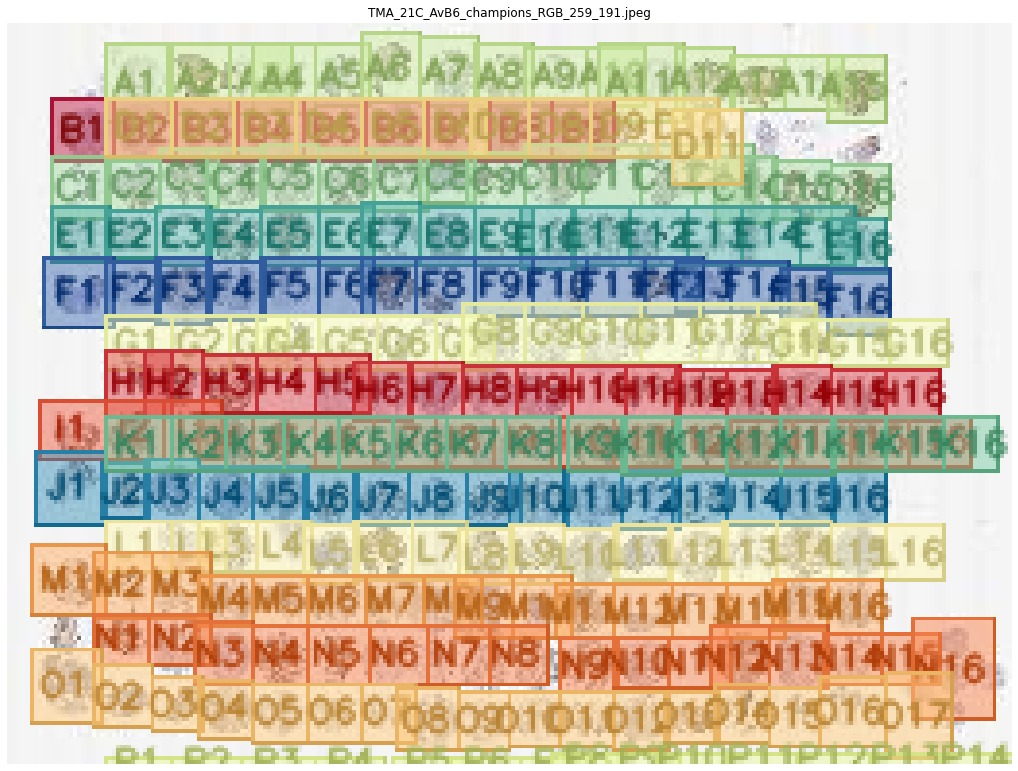

In [34]:
plt = plot_image(bb_lbl_map, path_to_resized, opacity = config["function_config"]["plot_figure"]["opacity"], cmap = config["function_config"]["plot_figure"]["cmap"],plot_row_boundaries = config["function_config"]["plot_figure"]["plot_row_boundaries"],plot_box_midline = config["function_config"]["plot_figure"]["plot_box_midline"],
upper_cp = config["function_config"]["plot_figure"]["upper_cp"])


In [22]:
#items4

In [33]:
'''
@tf.function
def rgb2hsd(img):
    lower_clip = 1e-2
    eps = tf.constant(1e-7)
    log10 = tf.math.log(tf.constant(10.0))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.where(img<lower_clip, tf.multiply(lower_clip, tf.ones_like(img)), img)
    OD = tf.divide(tf.multiply(tf.constant(-1.0), tf.math.log(img)), log10)
    D = tf.reduce_mean(OD, axis=-1)
    D = tf.where(D==0.0, tf.multiply(eps, tf.ones_like(D)), D)
    cx = tf.subtract(tf.divide(OD[:,:,0], D), tf.constant(1.0))
    cx = tf.where(cx==0.0, tf.multiply(eps, tf.ones_like(cx)), cx)
    cy = tf.divide(tf.subtract(OD[:,:,1], OD[:,:,2]), tf.multiply(tf.sqrt(tf.constant(3.0)), D))
    D = tf.expand_dims(D, -1)
    cx = tf.expand_dims(cx, -1)
    cy = tf.expand_dims(cy, -1)
    img = tf.concat((D,cx,cy), -1)
    return img

def clean_image(image, sigma=3, t=0.9):
    blur = skimage.color.rgb2gray(image)
    blur = skimage.filters.gaussian(blur, sigma=sigma)
    mask = blur < t
    
    sel = np.ones_like(image)*255
    sel[mask] = image[mask]
    
    image = tf.convert_to_tensor(sel)
   
    return image

def preprocess_cd228(img, c_crop=0.85, resize_to=(2048,2048)):
    print('in new preprocess_cd228')
    img = clean_image(img)
    img = rgb2hsd(img)
    img = tf.image.central_crop(img, c_crop)
    img = tf.image.resize(img, resize_to)
    return img


def preprocess_slc1a5(img, c_crop=0.85, resize_to=(2048,2048)):
    img = clean_image(img, 2, 0.93)
    img = tf.image.central_crop(img, c_crop)
    img = tf.cast(tf.image.resize(img, resize_to), dtype=tf.uint8)  
    return img/255

'''

def test_patho_inference(items):
    """Receives a tuple, performs pathology model prediction
    
    Args:
        items (tuple): (lists of cores for slide images)
    
    Returns:
        tuple(core_directory, filename, gcs_path, destination_path_cd228, destination_path_slc1a5,image_class)
        """
    logging.info("***********Performing Inference")
    #core, filename, gcs_path, image_class = items
    gcs_path, conf_scores, bboxes, filename, local_svs_path, image_class = items
    
    '''
    logging.info("Core list values are : {}".format(' '.join(map(str, core))))   
    core = {'name': core[0], 'path':  core[1], 'pathology_model_1':  core[2], 'pathology_model_2':  core[3]}
    tma_core_path = core["path"].replace("https://storage.cloud.google.com/", "gs://")
    _, path = extract_from_gcs2(tma_core_path)
    '''
    
    filename = 'l-5_core.png'
    path = filename
    img = np.asarray(Image.open(path))
    
    cd228_core_img = preprocess_cd228(img)
    slc1a5_core_img = preprocess_slc1a5(img)
        
    parent_dir = os.getcwd()
    folder_path1 = parent_dir + "/PreprocessedImages"
    if not os.path.exists(folder_path1):
        os.mkdir(folder_path1)
    
    cd_fpath = folder_path1 + "/cd228_" +  filename  + ".png"
    cd_img = tf.cast(65535.0*(cd228_core_img + 1.732052)/3.732055, tf.uint16).numpy()
    cv2.imwrite(cd_fpath, cd_img)
        
    slc_fpath = folder_path1 + "/slc1a5_" +  filename  + ".png"
    slc_img = tf.cast(65535.0*slc1a5_core_img, tf.uint16).numpy()
    cv2.imwrite(slc_fpath, slc_img)
      
    PROJECT_NAME = "ihc-qc-sandbox"
        
    predictions_cd = predict_cloud_model_patho(PROJECT_NAME, "1796285340437184512", cd_fpath)
    predictions_slc = predict_cloud_model_patho(PROJECT_NAME, "3949005962320281600", slc_fpath)
    
    s = round(predictions_slc[0]['s'][0], 3)
    i = round(predictions_slc[0]['i']*3.0, 3)
    f = round(predictions_slc[0]['f']*4.0, 3)
    mi = float(predictions_cd[0]["mi"])*3.0
    md = float(predictions_cd[0]["md"])*4.0
    ci = float(predictions_cd[0]["ci"])*3.0
    cd = float(predictions_cd[0]["cd"])*4.0  
    
    folder_path = parent_dir+"/InferenceVisualization"
    destination_path_cd228 = folder_path+"/cd228_"+filename
    destination_path_slc1a5 = folder_path+"/slc1a5_"+filename
    
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        
    plt.imsave(destination_path_cd228, predictions_cd[0]["activation_2"], cmap="Spectral")
    plt.imsave(destination_path_slc1a5, predictions_slc[0]["attention_layer"], cmap="Spectral")
    
    #os.remove(filename)
    #os.remove(cd_fpath)
    #os.remove(slc_fpath)
    
    core_directory = filename.rsplit("_Original", 1)[0]
        
    return (core_directory, filename, gcs_path, destination_path_cd228, destination_path_slc1a5, image_class, mi, md, ci, cd, s, i, f)

In [34]:
core_directory, filename, gcs_path, destination_path_cd228, destination_path_slc1a5,image_class, mi, md, ci, cd, s, i, f = test_patho_inference(items4)

INFO:root:***********Performing Inference
INFO:root:***Estimated size encoding:  4.7474565505981445 MB 
INFO:root:response
INFO:root: deployed_model_id:  1947252684977340416
INFO:root:***Estimated size encoding:  3.926823616027832 MB 
INFO:root:response
INFO:root: deployed_model_id:  2133026169606373376


In [35]:
core_directory, filename, gcs_path, destination_path_cd228, destination_path_slc1a5,image_class, mi, md, ci, cd, s, i, f

('l-5_core.png',
 'l-5_core.png',
 'gs://ihc_dataset/ChampionsTMA_21-24/TMA_21C_AvB6_champions.svs',
 '/home/jupyter/seattle-quantiphi/TMA/InferenceVisualization/cd228_l-5_core.png',
 '/home/jupyter/seattle-quantiphi/TMA/InferenceVisualization/slc1a5_l-5_core.png',
 'tma',
 2.997397542,
 2.45840478,
 0.1671196482,
 4.0,
 0.001,
 0.006,
 0.001)

In [79]:
def test_predict_image_object_detection_sample:
    predict_image_object_detection_sample(('gs://ihc_dataset/ChampionsTMA_21-24/champions_26103_TMA21.svs',
 'tma',/
 'champions_26103_TMA21_Original_1120_796.png',
 '/hochampions_me/jupyter/seattle-quantiphi/TMA/cores/champions_26103_TMA21.svs'),
    "ihc-qc-sandbox",
    "4721514035902676992",
    "0.025")==('gs://ihc_dataset/ChampionsTMA_21-24/champions_26103_TMA21.svs',
 array([0.99995112, 0.99990678, 0.99986875, 0.99985087, 0.99984658,
        0.99974412, 0.99970066, 0.99969792, 0.99968314, 0.9996438 ,
        0.99962533, 0.99952054, 0.99952006, 0.99950874, 0.99950862,
        0.99950504, 0.99944872, 0.99943989, 0.99940836, 0.99939978,
        0.99937159, 0.99935085, 0.9993487 , 0.99926394, 0.99912924,
        0.99910623, 0.9990809 , 0.99904484, 0.9990446 , 0.99903393,
        0.99901295, 0.99897718, 0.9989692 , 0.99894637, 0.99893409,
        0.9988789 , 0.99887782, 0.99885488, 0.9988243 , 0.99878687,
        0.99874228, 0.99869627, 0.99869174, 0.998691  , 0.99868196,
        0.99863142, 0.99862349, 0.99860829, 0.99859756, 0.99857831,
        0.99855703, 0.99854809, 0.99844933, 0.99843627, 0.99840945,
        0.99835867, 0.9983387 , 0.99832922, 0.9983241 , 0.99831748,
        0.99831426, 0.99786747, 0.99782085, 0.99776888, 0.9977228 ,
        0.99767584, 0.99758267, 0.99747783, 0.99745351, 0.9973864 ,
        0.99728215, 0.99720925, 0.99695456, 0.99695063, 0.99658585,
        0.99656326, 0.99646133, 0.99635327, 0.99634486, 0.996318  ,
        0.99624443, 0.99612915, 0.995924  , 0.99588156, 0.99579054,
        0.99563968, 0.9954015 , 0.99528474, 0.99481225, 0.994491  ,
        0.9944036 , 0.99415368, 0.99404657, 0.9939884 , 0.99386036,
        0.99317729, 0.99276769, 0.99216968, 0.99206841, 0.99133331,
        0.99114311, 0.99075365, 0.99007684, 0.98963869, 0.98909658,
        0.98874378, 0.98845041, 0.98688835, 0.98653191, 0.98578578,
        0.98346275, 0.98278272, 0.981198  , 0.97871405, 0.97837925,
        0.976585  , 0.970554  , 0.96708429, 0.96436763, 0.96242434,
        0.95864242, 0.95464307, 0.9527809 , 0.95068312, 0.94738275,
        0.92873812, 0.92491537, 0.92212915, 0.92071855, 0.91303116,
        0.89838463, 0.89426136, 0.88884491, 0.88288593, 0.880806  ,
        0.88049322, 0.7790879 , 0.7670384 , 0.74086249, 0.53647894,
        0.39647675, 0.39324519, 0.37727615, 0.30645695, 0.28255829,
        0.17866117, 0.15719078, 0.14612211, 0.13620664, 0.13107878,
        0.13029148, 0.12236376, 0.10887055, 0.07924014, 0.06121022,
        0.06116582, 0.05859731, 0.05776211, 0.04910345, 0.04228069,
        0.03979046, 0.03559705, 0.03473111, 0.03208411, 0.02524013,
        0.0207602 , 0.02068326, 0.0182409 , 0.01760214, 0.01542783,
        0.01454632, 0.01439474, 0.01369738, 0.01271428, 0.01145166,
        0.01139574, 0.00990697, 0.00972274, 0.00923766, 0.00627804,
        0.00553907, 0.00545226, 0.0052857 , 0.00523446, 0.00521425,
        0.00497657, 0.00487907, 0.00478198, 0.00467652, 0.00462452,
        0.00461941, 0.00404241, 0.00403948, 0.00377697, 0.00356937,
        0.00346809, 0.00332462, 0.00314957, 0.00298488, 0.00294969]),
 array([[0.17702918, 0.23768175, 0.57026935, 0.6618728 ],
        [0.23066045, 0.29187915, 0.51011437, 0.59205174],
        [0.1215842 , 0.18283467, 0.568403  , 0.65917748],
        [0.53046614, 0.58542734, 0.81034887, 0.88709736],
        [0.64277923, 0.69708449, 0.6747762 , 0.75263447],
        [0.39285135, 0.44827259, 0.25520685, 0.33354941],
        [0.45245302, 0.50831991, 0.04279129, 0.11604981],
        [0.42986542, 0.48660529, 0.73582232, 0.81792527],
        [0.7369135 , 0.79619104, 0.812678  , 0.89583528],
        [0.33485392, 0.39549312, 0.38478258, 0.46787152],
        [0.24050979, 0.29796857, 0.17248332, 0.25213283],
        [0.81254733, 0.8663224 , 0.1577777 , 0.22956519],
        [0.81205708, 0.86811525, 0.07908117, 0.15822098],
        [0.08230776, 0.13804683, 0.23831746, 0.31458184],
        [0.65957749, 0.71300834, 0.06289874, 0.13895591],
        [0.49040136, 0.54764146, 0.4610931 , 0.53923297],
        [0.48839793, 0.54509866, 0.596178  , 0.67412436],
        [0.13567482, 0.19079325, 0.31243142, 0.3894755 ],
        [0.19161667, 0.24787259, 0.09706378, 0.17414524],
        [0.7124142 , 0.76670283, 0.06757679, 0.14906914],
        [0.80244732, 0.85601568, 0.68071306, 0.75369447],
        [0.02309109, 0.0884495 , 0.42665428, 0.519225  ],
        [0.13603696, 0.19010249, 0.23887971, 0.31353009],
        [0.597261  , 0.6530956 , 0.54265135, 0.61806071],
        [0.53678578, 0.59486866, 0.67292774, 0.76177043],
        [0.2811234 , 0.3367945 , 0.58373511, 0.65937817],
        [0.11825887, 0.17676857, 0.76905411, 0.85582256],
        [0.65126586, 0.70196229, 0.54277646, 0.61890608],
        [0.49507293, 0.550753  , 0.2592696 , 0.3383674 ],
        [0.0282098 , 0.08554503, 0.2335768 , 0.31032407],
        [0.7996065 , 0.85785884, 0.60827076, 0.68220615],
        [0.80945212, 0.862218  , 0.22467577, 0.29617408],
        [0.55873025, 0.61104375, 0.05374056, 0.13126437],
        [0.01618365, 0.07901882, 0.68379057, 0.77390623],
        [0.40069792, 0.45415127, 0.18156362, 0.2582241 ],
        [0.50353324, 0.55746937, 0.12375417, 0.19795078],
        [0.29656425, 0.35117128, 0.17405511, 0.25058994],
        [0.7926724 , 0.85197407, 0.81323218, 0.89598703],
        [0.08907577, 0.14360776, 0.02915971, 0.10145854],
        [0.60945719, 0.66239184, 0.05847654, 0.1382391 ],
        [0.24551541, 0.29820052, 0.09592979, 0.17139141],
        [0.35188556, 0.4125278 , 0.02542198, 0.11296814],
        [0.38022265, 0.43361306, 0.66592425, 0.73922026],
        [0.28897366, 0.34574723, 0.32006624, 0.39772031],
        [0.47759622, 0.53220719, 0.81168044, 0.88464373],
        [0.34393197, 0.39608505, 0.31754676, 0.38891447],
        [0.59712505, 0.65156943, 0.40505809, 0.47743693],
        [0.38898778, 0.43979731, 0.45893368, 0.52883041],
        [0.74844056, 0.8037324 , 0.672618  , 0.75218052],
        [0.27975845, 0.33573231, 0.65661532, 0.73308241],
        [0.40234217, 0.45498249, 0.10778053, 0.18162157],
        [0.18725891, 0.24317454, 0.24609347, 0.32112017],
        [0.45208394, 0.50638843, 0.18996304, 0.26318079],
        [0.65375733, 0.70822233, 0.13926473, 0.21138135],
        [0.2927793 , 0.34739956, 0.25161624, 0.3238976 ],
        [0.24130832, 0.29360005, 0.25034928, 0.32550895],
        [0.38530934, 0.4396846 , 0.5282445 , 0.59721607],
        [0.18520485, 0.24182689, 0.44511   , 0.52217275],
        [0.65371627, 0.70732075, 0.20815508, 0.28290111],
        [0.58316469, 0.64293456, 0.80467558, 0.88656   ],
        [0.43884829, 0.49030593, 0.46231008, 0.53582567],
        [0.17192546, 0.22958997, 0.77351808, 0.86167079],
        [0.50493932, 0.56085479, 0.04564921, 0.12329351],
        [0.08347016, 0.13575476, 0.31395832, 0.38976124],
        [0.22591783, 0.28218493, 0.79202235, 0.86722481],
        [0.75776088, 0.80971211, 0.22249331, 0.29246515],
        [0.7544058 , 0.8046521 , 0.2899479 , 0.36070281],
        [0.48284045, 0.539186  , 0.67079312, 0.75205094],
        [0.22587565, 0.28112367, 0.65245259, 0.72447211],
        [0.28542885, 0.33889335, 0.44836581, 0.52747005],
        [0.59810239, 0.65272963, 0.47479782, 0.54489845],
        [0.49501646, 0.54838258, 0.39096141, 0.46323746],
        [0.57780826, 0.63089609, 0.8829599 , 0.96326405],
        [0.76103127, 0.81347042, 0.15378259, 0.22430406],
        [0.14220539, 0.19682196, 0.02830735, 0.10121043],
        [0.54932743, 0.6036709 , 0.19534667, 0.26773059],
        [0.27503   , 0.33924562, 0.72915482, 0.81186616],
        [0.18550664, 0.24151816, 0.17346247, 0.24868475],
        [0.43688258, 0.49037051, 0.59657365, 0.66850853],
        [0.02805795, 0.09008751, 0.09775381, 0.1853849 ],
        [0.80406916, 0.85938853, 0.29681048, 0.36674687],
        [0.08484283, 0.13956894, 0.17246215, 0.24202709],
        [0.3754898 , 0.42978627, 0.8034538 , 0.87394697],
        [0.80591464, 0.85994148, 0.36739942, 0.43861976],
        [0.54267222, 0.596914  , 0.60522544, 0.67676896],
        [0.45318413, 0.50561237, 0.11898107, 0.19067429],
        [0.3496367 , 0.4030579 , 0.1100639 , 0.1793559 ],
        [0.43949941, 0.49549511, 0.39374009, 0.46470693],
        [0.08607334, 0.14016631, 0.10370249, 0.17494537],
        [0.549326  , 0.60238969, 0.26379222, 0.33777681],
        [0.557575  , 0.60936117, 0.12833403, 0.19526887],
        [0.13166885, 0.18791184, 0.44199136, 0.52102423],
        [0.03237411, 0.09093823, 0.02466215, 0.10052877],
        [0.59419036, 0.64939839, 0.61299777, 0.684309  ],
        [0.37070587, 0.42986581, 0.87331104, 0.95881331],
        [0.29856029, 0.35148284, 0.10427383, 0.17658159],
        [0.07660906, 0.1306608 , 0.50642425, 0.57728344],
        [0.5932734 , 0.64446163, 0.68306541, 0.75960022],
        [0.70796853, 0.76105756, 0.14874202, 0.22346142],
        [0.29228932, 0.35361382, 0.02493614, 0.10788199],
        [0.74273455, 0.79886711, 0.74777251, 0.81597048],
        [0.68223256, 0.7387386 , 0.88659865, 0.96522433],
        [0.54782605, 0.60086334, 0.33527616, 0.40597969],
        [0.34893763, 0.40262005, 0.18105316, 0.25923395],
        [0.59901684, 0.65092635, 0.33578712, 0.40523747],
        [0.59863615, 0.65317416, 0.27008793, 0.33911619],
        [0.22477016, 0.28056362, 0.7223208 , 0.79355258],
        [0.8027947 , 0.85533804, 0.48001352, 0.553814  ],
        [0.18989973, 0.24239987, 0.31965077, 0.38777888],
        [0.70672631, 0.75944966, 0.22331069, 0.2926313 ],
        [0.01932942, 0.08680736, 0.56160122, 0.65017742],
        [0.65204918, 0.70711297, 0.28327751, 0.35741383],
        [0.42823523, 0.48158574, 0.87834394, 0.95753747],
        [0.01719101, 0.0735781 , 0.76723504, 0.83932739],
        [0.33458996, 0.38790643, 0.59229177, 0.66208953],
        [0.65196312, 0.7042287 , 0.47763854, 0.54196852],
        [0.76345169, 0.8143459 , 0.07609165, 0.15456322],
        [0.06892663, 0.12458645, 0.769965  , 0.85004813],
        [0.69518763, 0.75065666, 0.67046803, 0.75159985],
        [0.68287844, 0.74005866, 0.81382406, 0.89068645],
        [0.015667  , 0.08248556, 0.83311665, 0.91772133],
        [0.18974328, 0.24369499, 0.38463572, 0.44748905],
        [0.42836982, 0.48063272, 0.81152207, 0.88197106],
        [0.65184629, 0.70745361, 0.40721381, 0.48209527],
        [0.08371934, 0.13361538, 0.44551563, 0.5114302 ],
        [0.54876369, 0.59732491, 0.40152657, 0.46947041],
        [0.13481197, 0.1892357 , 0.38683674, 0.44791189],
        [0.22586445, 0.28136912, 0.86700171, 0.93553567],
        [0.75110233, 0.80607605, 0.36112076, 0.42793369],
        [0.69909632, 0.74949   , 0.4126052 , 0.48081604],
        [0.33348608, 0.3873395 , 0.523283  , 0.59341723],
        [0.3777369 , 0.43054307, 0.73643529, 0.80822176],
        [0.52833474, 0.57976985, 0.88671762, 0.95938486],
        [0.54880595, 0.59743482, 0.46673253, 0.53481525],
        [0.69749147, 0.758666  , 0.53933507, 0.62954855],
        [0.79826438, 0.85077757, 0.7533896 , 0.81802255],
        [0.43195409, 0.48566744, 0.66786867, 0.74064577],
        [0.16953792, 0.22439589, 0.85894483, 0.93787128],
        [0.43879542, 0.49057943, 0.53150821, 0.59773606],
        [0.78239125, 0.85361284, 0.89112318, 0.98211169],
        [0.23580994, 0.28189567, 0.59033465, 0.65576959],
        [0.29788423, 0.36831096, 0.87187719, 0.9631182 ],
        [0.23714921, 0.28161892, 0.59328216, 0.65347576],
        [0.47715712, 0.5283168 , 0.88596046, 0.9610638 ],
        [0.47652772, 0.52867526, 0.8860966 , 0.96287882],
        [0.62854248, 0.68568462, 0.88286942, 0.96556348],
        [0.63192248, 0.68416822, 0.88039374, 0.9653064 ],
        [0.1702538 , 0.22603808, 0.85990536, 0.93686485],
        [0.78399831, 0.85674584, 0.89271069, 0.9804942 ],
        [0.43856618, 0.4910734 , 0.53200609, 0.59814441],
        [0.43280032, 0.4848603 , 0.67030728, 0.7376287 ],
        [0.29962882, 0.37041679, 0.87374479, 0.963635  ],
        [0.73682338, 0.79637545, 0.88698387, 0.97406751],
        [0.5277741 , 0.57981384, 0.88727581, 0.9650107 ],
        [0.79868734, 0.85261518, 0.75394148, 0.81864506],
        [0.37806597, 0.43056881, 0.73861492, 0.80887789],
        [0.54914069, 0.59825569, 0.46804824, 0.53600961],
        [0.33365691, 0.38632077, 0.5242449 , 0.59358787],
        [0.22545677, 0.28426278, 0.86275262, 0.93997389],
        [0.75089931, 0.80702889, 0.36215672, 0.42742229],
        [0.13457468, 0.18931121, 0.38736984, 0.44721919],
        [0.738874  , 0.79940712, 0.88680923, 0.97599083],
        [0.42845678, 0.48054823, 0.81236869, 0.8815766 ],
        [0.69837946, 0.76041406, 0.53638315, 0.62930977],
        [0.651661  , 0.70743144, 0.40865144, 0.48147255],
        [0.69931787, 0.75015503, 0.41159183, 0.480886  ],
        [0.54943621, 0.59762782, 0.4011465 , 0.47174439],
        [0.19003126, 0.24450764, 0.38571078, 0.44782695],
        [0.69732988, 0.7509315 , 0.67111075, 0.7518037 ],
        [0.08552735, 0.13402404, 0.44464716, 0.51180249],
        [0.76535434, 0.81475621, 0.0757282 , 0.15504639],
        [0.01513819, 0.08442673, 0.83558774, 0.92133003],
        [0.18697256, 0.24532019, 0.31748059, 0.39145544],
        [0.65130961, 0.70505858, 0.47754848, 0.54218555],
        [0.65137613, 0.71005088, 0.28110704, 0.36062482],
        [0.42789611, 0.48207402, 0.8788209 , 0.95903927],
        [0.70789486, 0.75893021, 0.22339903, 0.29256794],
        [0.01867523, 0.07771798, 0.76598388, 0.84721196],
        [0.33520457, 0.38710833, 0.5922879 , 0.66350877],
        [0.22368158, 0.28145835, 0.72194445, 0.80053234],
        [0.35159379, 0.40231383, 0.18118838, 0.25939247],
        [0.74002945, 0.8004846 , 0.74597669, 0.81957352],
        [0.60000181, 0.65315342, 0.27213031, 0.33839664],
        [0.59950566, 0.65090674, 0.33727586, 0.40510806],
        [0.08178134, 0.14324561, 0.17033033, 0.24804161],
        [0.80375356, 0.86343229, 0.36514068, 0.44219703],
        [0.54774386, 0.60084432, 0.33613574, 0.40667584],
        [0.70944577, 0.76071596, 0.14943412, 0.22279774],
        [0.75468016, 0.80721349, 0.2880545 , 0.36499441],
        [0.02055232, 0.08830914, 0.56052154, 0.65259254],
        [0.06994931, 0.12723981, 0.7687664 , 0.85190976],
        [0.59463286, 0.64879245, 0.61307216, 0.68413782],
        [0.59305489, 0.64467877, 0.68144149, 0.75915223],
        [0.68133   , 0.73941141, 0.81399703, 0.89372581],
        [0.29984882, 0.35130444, 0.10580201, 0.176058  ],
        [0.80093574, 0.85945135, 0.476616  , 0.558154  ],
        [0.55127794, 0.602261  , 0.26429394, 0.33615062],
        [0.07710566, 0.13168813, 0.50730473, 0.57792783],
        [0.18437438, 0.24120967, 0.17436548, 0.24889189],
        [0.08884959, 0.13958767, 0.10382158, 0.17571484]]),
 'champions_26103_TMA21_Original_1120_796.png',
 '/home/jupyter/seattle-quantiphi/TMA/cores/champions_26103_TMA21.svs',
 'tma')

SyntaxError: invalid syntax (785261347.py, line 1)

In [37]:
nbconvert Unit_test.ipynb --to script

SyntaxError: invalid syntax (<ipython-input-37-d61815bd9400>, line 1)